# Practical work 2 : Fourier transform

This practial work is dedicated to the study of the discrete Fourier transform applied on the two following images:
![son.png](./img/son.png)
![sonrot.png](./img/sonrot.png)
and analyze the properties of their spectrum. To this end, we make use of the following functions provided by the module `numpy.fft`:

- `fft2()` to compute the Fourier transform on an image
- `fftshift()` to center the low frequencies
- `abs()` (from `numpy`) to compute the module of a complexe array

In most of cases, high frequencies have lower energy compare to low frequencies. We will use a logarithmic scale by applying $\log(1+abs(TF))$ to display the spectrum.

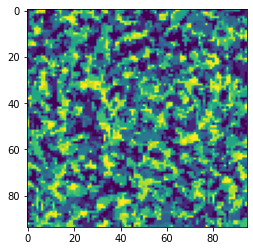

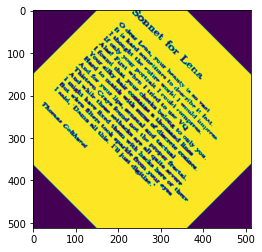

In [63]:
import numpy as np
from numpy.fft import fft2,fftshift
from PIL import Image
import matplotlib.pyplot as plt

sonrot = np.array(Image.open('img/sonrot.png'))
sonrot2 = np.array(Image.open('img/sonrot2.png'))

#sometime it open the image as a boolean array, that why i tranform everything in a int array [0-255]
son = np.array(Image.open('img/unknown.png')).astype(int)*255

son = np.dot(son[...,:3], [0.299, 0.587, 0.114])

plt.imshow(son)
plt.show()
plt.imshow(sonrot)
plt.show()

## Exercice: properties of Fourier transform applied on natural images
1. Write the following functions:
 - `computeFT(I)` returning the Fourier transform of image `I`,
 - `toVisualizeFT(If)` returning the centered module of a complex array `If` (the Fourier transform of an image),
 - `toVisualizeLogFT(If)` similar to the previous function but use a logarithmic scale.

In [64]:
def computeFT(I):
    """ Array -> Array[complex] """
    return fftshift(np.fft.fft2(I))

def toVisualizeFT(If):
    """ Array[complex] -> Array[float] """
    return np.abs(If)

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    #we use log10 and not ln
    return np.log10(1 + np.abs(If))


2. Write a series of instructions that
 - compute the Fourier transform of `son` and `sonrot`,
 - compute and display the module using a logarithmic scale,
 - threshold the module with a parameter of $1.10^5$ (use the function of TME1)
 - display the thresholded spectrum

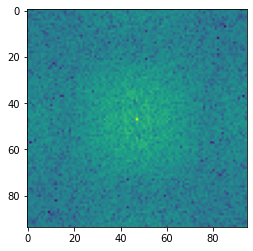

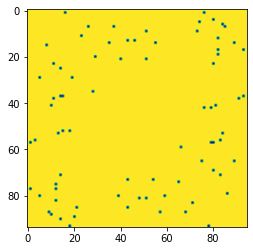

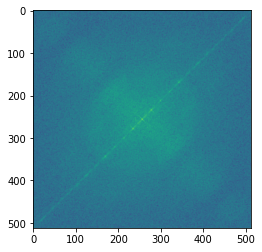

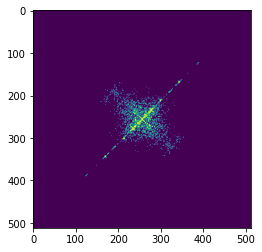

In [65]:
import matplotlib.pyplot as plt

#threshold function form the TME1
def thresholdImage(I,s):
    return np.where(I > s,255,0)


sonTF = computeFT(son)
sonLogTF = toVisualizeLogFT(sonTF)
plt.imshow(sonLogTF)
plt.show()

sonThresh = toVisualizeFT(sonTF)
plt.imshow(thresholdImage(sonThresh,100000))
plt.show()

#since we use it two time we put it into a var
sonrotTF = computeFT(sonrot2)

sonrotLogTF = toVisualizeLogFT(sonrotTF)
plt.imshow(sonrotLogTF)
plt.show()

sonrotThresh = toVisualizeFT(sonrotTF)
plt.imshow(thresholdImage(sonrotThresh,100000))
plt.show()

#on vois que la rotation de l'image se fait identiquement sur le plan des frequences

3. Interpretation: discuss the results obtained on thresholded FT module. What property of the Fourier transform is shown ?

4. Write the function `blend()` getting two images, one float parameter $\alpha\in[0,1]$, calculating $\alpha I_1+(1-\alpha)I_2$ and returning the result. 

In [72]:
def blend(I1,I2,alpha):
    return I1*alpha + I2*(1-alpha)

def blendLoop(I1,I2,alpha):
    shape = I1.shape
    B = np.zeros(shape)
    
    for x in range(shape[0]):
        for y in range(shape[0]):
            B[x][y] = I1[x][y]*alpha + I2[x][y]*(1-alpha)
    
    return B

def displayImageAndTF(I,s,showSpectrum=True):
    plt.imshow(I,cmap='gray')
    plt.show()

    if showSpectrum:
        IThresh = toVisualizeFT(computeFT(I))
        plt.imshow(thresholdImage(IThresh,s))
        plt.show()


5. Apply the previous function on images `son` and `sonrot` and $\alpha=\frac12$, compute the Fourier transform, threshold the module and visualize the result. 

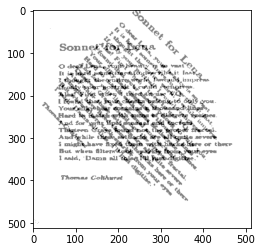

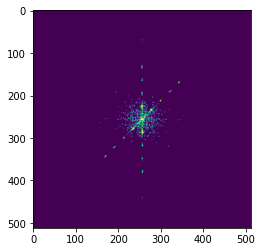

using compiled numpy C library :
100 loops, best of 5: 3.44 ms per loop
raw python :
1 loop, best of 5: 1.45 s per loop


In [73]:
#we show again that FT are also additive in the frequence domain

sonBlendRot = blend(son,sonrot2, 0.5)
displayImageAndTF(sonBlendRot,100000)

print('using compiled numpy C library :')
%timeit blend(son,sonrot2, 0.5)
print('raw python :')
%timeit blendLoop(son,sonrot2, 0.5)

6. Compare the latter result with those of question 2: what property of the Fourier transform is shown? What is the behaviour of $\alpha$ in the resulting spectrum?

The additive properity of the frecency is the same as the 2D array, so 𝛼 define how much each spectrum should be added together (ex: 𝛼 = 0.25 (25%I1 + 75%I2) 

7. We want to determine the text orientation in image `sonrot` and produce a new image with horizontal text. Write the function `rectifyOrientation()` that:

 + computes the FT module of image given in parameter and threshold it at $3\times 10^{5}$,
 + from thresholded module determines the main orientation using the function `mainOrientation()` 
 + produces the rectified image applying a rotation with a suitable angle using `rotateImage()`

In [81]:
def mainOrientation(I):
    """ Array -> tuple[Iori,float]
        return image of orientation (32 bins) and the main orientation (degree) from a Fourier transform module
    """
    n, m = I.shape

    size = 32
    x = np.array(range(size))
    ori = np.vstack((np.cos(np.pi*x/size), np.sin(np.pi*x/size))).T

    Iori = np.zeros((n, m))
    orients = np.zeros((size))

    for i in range(1,n+1):
        for j in range(1,m+1):
            if I[i-1, j-1] > 0:
                v = np.array([j-m/2, -i + n/2])
                if i > n/2:
                    v = -v
                    prod = np.matmul(ori, v)
                    maxi = prod.max()
                    if maxi > 0:
                        imax = np.nonzero(prod == maxi)
                        Iori[i-1, j-1] = imax[0]
                        orients[imax] += 1

    maxori = np.nonzero(orients == orients.max())[0][0]
    return (Iori, 180*maxori/size - 90)

def rotateImage(I,a):
    """ Array*float -> Array 
        return a rotation of angle a (degree) of image I
    """
    return np.array(Image.fromarray(I).rotate(a, expand=True, fillcolor=127))

####### your code below

def rectifyOrientation(I):
    IFT = computeFT(I)
    IFTd = toVisualizeFT(IFT)
    IFTthresh = thresholdImage(IFTd,100000)
    return rotateImage(I,-mainOrientation(IFTthresh)[1])

8. Experiment `rectifyOrientation()` on `sinrot`, and on a rotation of `img/port.jpg` (using `rotateImage()`) with various rotation angles.  

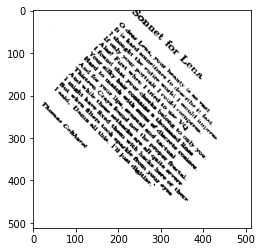

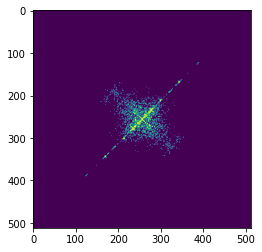

-45.0


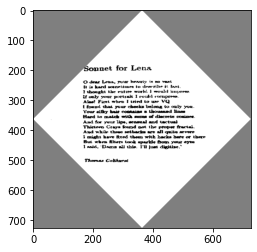

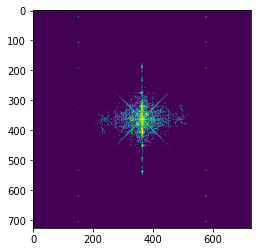

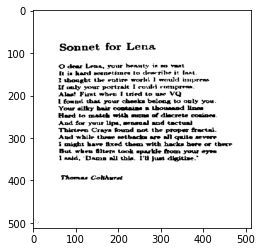

with a rotation of :  45 °
45.0


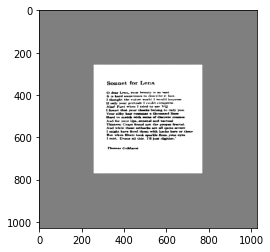

In [91]:
displayImageAndTF(sonrot2,100000)
displayImageAndTF(rectifyOrientation(sonrot2),100000)


displayImageAndTF(son,0,False)

#many test case
for x in range(0,1):
    rot = 45
    print("with a rotation of : ", rot, "°")
    sonrottest = rotateImage(son,rot)
    displayImageAndTF(rectifyOrientation(sonrottest),0,False)
